<a href="https://colab.research.google.com/github/ElijahLewisUWI/COMP3610-A3/blob/main/BigData_A3_Full_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install HuggingFace datasets
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
import os
import pandas as pd
import random
from datasets import load_dataset
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# Connecting the Google Drive to Colab to store the datasets



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Output paths
base_dir = "/content/drive/MyDrive/amazon_data_2023"
os.makedirs(base_dir, exist_ok=True)

review_csv = os.path.join(base_dir, "amazon_data_review.csv")
meta_csv = os.path.join(base_dir, "amazon_data_meta.csv")

# 1. Data Aquisition
# a) Obtain the Entire Dataset

# Sampling Amazon Metadata

This part of the code is used to collect a sample of Amazon product metadata from all categories. Since the full dataset is too large to process all at once, we take a smaller, manageable sample from each category.

1. The function **sample_meta()** loads meta from the Hugging Face dataset McAuley-Lab/Amazon-Reviews-2023. For each category, it randomly selects 2000 metadata and stops reading after 5 million entries to keep things efficient.

2. The parent_asin is saved into a set called collected_asins. This is a suprise tool that will help us later! (Join review data with item meta)

3. Then, each category's sample is saved to a CSV file (meta_csv)and the categories that have already been processed is being tracked using a text file called completed_categories.txt (if the script crashes or needs to be rerun)

4. To be safe and avoid hitting any limits, short pauses (time.sleep) was added between processing each category (A LOT OF CLIENT/REQUEST ERROR)

The output should be:

*   A combined CSV with thousands of metadata across multiple categories.
*   A list of unique parent_asin values to use when merging with reviews.
*   A progress file that tells us which categories are done.

Reference:
https://colab.research.google.com/drive/1sEQvZK94lk_YD4dc_g9m9RhtrFcut6VU?usp=sharing


In [ ]:
import time


meta_categories = [
    "raw_meta_All_Beauty", "raw_meta_Amazon_Fashion", "raw_meta_Appliances",
    "raw_meta_Arts_Crafts_and_Sewing", "raw_meta_Automotive", "raw_meta_Baby_Products",
    "raw_meta_Beauty_and_Personal_Care", "raw_meta_Books", "raw_meta_CDs_and_Vinyl", "raw_meta_Cell_Phones_and_Accessories",
    "raw_meta_Clothing_Shoes_and_Jewelry", "raw_meta_Digital_Music", "raw_meta_Electronics",
    "raw_meta_Gift_Cards", "raw_meta_Grocery_and_Gourmet_Food", "raw_meta_Handmade_Products",
    "raw_meta_Health_and_Household", "raw_meta_Health_and_Personal_Care", "raw_meta_Home_and_Kitchen",
    "raw_meta_Industrial_and_Scientific", "raw_meta_Kindle_Store", "raw_meta_Magazine_Subscriptions", "raw_meta_Movies_and_TV",
    "raw_meta_Musical_Instruments", "raw_meta_Office_Products", "raw_meta_Patio_Lawn_and_Garden", "raw_meta_Pet_Supplies",
    "raw_meta_Software", "raw_meta_Sports_and_Outdoors", "raw_meta_Subscription_Boxes", "raw_meta_Tools_and_Home_Improvement",
    "raw_meta_Toys_and_Games", "raw_meta_Video_Games", "raw_meta_Unknown"
]

collected_asins = set() # store unique ASINs here

# Function to randomly sample metadata and collect ASINs
def sample_meta(meta_cat, sample_size=25000, seed=42):
    print(f"Sampling metadata from: {meta_cat}")
    random.seed(seed)

    # a) Obtain the Entire* Dataset
    dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", name=meta_cat, split="full", streaming=True, trust_remote_code=True)

    sample = []
    # *only a sample size of 25000 for each cat is retrieved
    for idx, example in enumerate(dataset):
        if idx < sample_size:
            sample.append(example)
        else:
            r = random.randint(0, idx)
            if r < sample_size:
                sample[r] = example
        if idx > 5_000_000:
            break

    df = pd.DataFrame(sample)

    # collect ASINs
    if 'parent_asin' in df.columns:
        collected_asins.update(df['parent_asin'].dropna().tolist())


    df.to_csv(meta_csv, mode='a', header=not os.path.exists(meta_csv), index=False)
    print(f"Saved {len(df)} meta from {meta_cat}")
    time.sleep(2) # I am not a robot
    return True


completed_categories = set() # to track the cat that was already processed
if os.path.exists("completed_categories.txt"):
    with open("completed_categories.txt", "r") as f:
        completed_categories = set(line.strip() for line in f)


for meta_cat in tqdm(meta_categories, desc="Sampling meta one-by-one"):
    if meta_cat in completed_categories:
        print(f"Skipping {meta_cat}, already processed.")
        continue
    try:
        sample_meta(meta_cat)
        with open("completed_categories.txt", "a") as f:
            f.write(meta_cat + "\n")
        time.sleep(5) # Let me in pleasee
    except Exception as e:
        print(f"Error while processing {meta_cat}: {e}")


print(f"\nCollected {len(collected_asins)} unique ASINs from meta")

Sampling meta one-by-one:   0%|          | 0/34 [00:00<?, ?it/s]

Sampling metadata from: raw_meta_All_Beauty


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

Saved 25000 meta from raw_meta_All_Beauty
Sampling metadata from: raw_meta_Amazon_Fashion
Saved 25000 meta from raw_meta_Amazon_Fashion
Sampling metadata from: raw_meta_Appliances
Saved 25000 meta from raw_meta_Appliances
Sampling metadata from: raw_meta_Arts_Crafts_and_Sewing
Saved 25000 meta from raw_meta_Arts_Crafts_and_Sewing
Sampling metadata from: raw_meta_Automotive
Saved 25000 meta from raw_meta_Automotive
Sampling metadata from: raw_meta_Baby_Products
Saved 25000 meta from raw_meta_Baby_Products
Sampling metadata from: raw_meta_Beauty_and_Personal_Care
Saved 25000 meta from raw_meta_Beauty_and_Personal_Care
Sampling metadata from: raw_meta_Books
Saved 25000 meta from raw_meta_Books
Sampling metadata from: raw_meta_CDs_and_Vinyl
Saved 25000 meta from raw_meta_CDs_and_Vinyl
Sampling metadata from: raw_meta_Cell_Phones_and_Accessories
Saved 25000 meta from raw_meta_Cell_Phones_and_Accessories
Sampling metadata from: raw_meta_Clothing_Shoes_and_Jewelry
Saved 25000 meta from raw_me

In [ ]:
meta_df = pd.read_csv(meta_csv)

print("Shape:", meta_df.shape)

<ipython-input-7-b299587051ac>:1: DtypeWarning: Columns (6,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(meta_csv)


Shape: (780169, 16)


After sampling the metadata, we can focus on collecting the matching user review based on the parent_asin (Product ID).

1. Similar to the above code, we keep track of which review categories we’ve already processed using a file called completed_review.txt. This helps avoid downloading the same data twice if we rerun the code.

2. The function fetch_matching_reviews() loads reviews for specific categories. It streams through each category and checks if its parent_asin matches one of the ASINs we collected from metadata. Save to the list if so.

3. While running the code, it had request errors and it was noted that it would reload and scan the categories again. To prevent this, once all matching metadata is found for a particular category, it’s saved to its own temporary CSV file (e.g. temp_metadata_Electronics.csv). This helps keep each category separate until we’re ready to merge everything.

4. After collecting metadata from all categories, all the temporary files are loaded and combined into one big DataFrame. Then remove duplicates based on the parent_asin and save the final cleaned and deduplicated metadata to meta_csv. Bonus: All temporary files are deleted for space management.

Output:
* A clean reviews file

In [ ]:
completed_cat = set() #to track the cat

if os.path.exists("completed_reviews.txt"):
    with open("completed_reviews.txt", "r") as f:
        completed_cat = set(line.strip() for line in f)

# Function to load reviews based on the matching ASINs of reviews
def fetch_matching_reviews(rev_cat):
    print(f"Scanning reviews: {rev_cat}")
    matches = []
    try:
        dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", name=rev_cat, split="full", streaming=True, trust_remote_code=True)
        for item in dataset:
            asin = item.get("parent_asin") or item.get("asin") # ASINs
            if asin in collected_asins:
              matches.append(item)

              if len(matches) >= 100000:
                break

        if matches: # if it matches, store it in its temporary cat file
            df = pd.DataFrame(matches)
            temp_filename = f"temp_reviews_{rev_cat}.csv"
            df.to_csv(temp_filename, index=False)
            print(f"Saved {len(matches)} matches to {temp_filename}")

            # Log completed category
            with open("completed_reviews.txt", "a") as f:
                f.write(rev_cat + "\n")
        else:
            print(f"No matches found in {rev_cat}")
        return True

    except Exception as e:
        print(f"Error in {rev_cat}: {e}")
        return False

    finally:
        time.sleep(5) # Let me in pleasee

categories = [
    "raw_review_All_Beauty", "raw_review_Amazon_Fashion", "raw_review_Appliances",
    "raw_review_Arts_Crafts_and_Sewing", "raw_review_Automotive", "raw_review_Baby_Products",
    "raw_review_Beauty_and_Personal_Care", "raw_review_Books","raw_review_CDs_and_Vinyl","raw_review_Cell_Phones_and_Accessories",
    "raw_review_Clothing_Shoes_and_Jewelry", "raw_review_Digital_Music", "raw_review_Electronics",
    "raw_review_Gift_Cards", "raw_review_Grocery_and_Gourmet_Food", "raw_review_Handmade_Products",
    "raw_review_Health_and_Household", "raw_review_Health_and_Personal_Care", "raw_review_Home_and_Kitchen",
    "raw_review_Industrial_and_Scientific", "raw_review_Kindle_Store", "raw_review_Magazine_Subscriptions", "raw_review_Movies_and_TV",
    "raw_review_Musical_Instruments", "raw_review_Office_Products", "raw_review_Patio_Lawn_and_Garden", "raw_review_Pet_Supplies",
    "raw_review_Software", "raw_review_Sports_and_Outdoors", "raw_review_Subscription_Boxes", "raw_review_Tools_and_Home_Improvement",
    "raw_review_Toys_and_Games", "raw_review_Video_Games", "raw_review_Unknown"
]

for category in tqdm(categories, desc="Fetching reviews"):
    if category in completed_cat:
        print(f"Skipping {category} (already completed)")
        continue
    try:
        fetch_matching_reviews(category)
        time.sleep(3)
    except Exception as e:
        print(f"Error in {category}: {e}")

print("\n Merging all review files...")
temp_files = [f for f in os.listdir() if f.startswith("temp_reviews") and f.endswith(".csv")]

# deduplication
all_dfs = []
for f in temp_files:
    df = pd.read_csv(f)
    all_dfs.append(df)

if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df.drop_duplicates(subset='parent_asin', inplace=True)
    combined_df.to_csv(review_csv, index=False) # save to the meta csv
    print(f" Final deduplicated reviews saved to: {review_csv}")
else:
    print(" No review files found to merge.")

# delete temporary files for storage
for f in temp_files:
    os.remove(f)

print("All review files are saved in review_csv!")

Fetching reviews:   0%|          | 0/34 [00:00<?, ?it/s]

Skipping raw_review_All_Beauty (already completed)
Skipping raw_review_Amazon_Fashion (already completed)
Skipping raw_review_Appliances (already completed)
Skipping raw_review_Arts_Crafts_and_Sewing (already completed)
Skipping raw_review_Automotive (already completed)
Skipping raw_review_Baby_Products (already completed)
Skipping raw_review_Beauty_and_Personal_Care (already completed)
Scanning reviews: raw_review_Books
Saved 100000 matches to temp_reviews_raw_review_Books.csv
Scanning reviews: raw_review_CDs_and_Vinyl
Saved 100000 matches to temp_reviews_raw_review_CDs_and_Vinyl.csv
Skipping raw_review_Cell_Phones_and_Accessories (already completed)
Skipping raw_review_Clothing_Shoes_and_Jewelry (already completed)
Skipping raw_review_Digital_Music (already completed)
Skipping raw_review_Electronics (already completed)
Skipping raw_review_Gift_Cards (already completed)
Skipping raw_review_Grocery_and_Gourmet_Food (already completed)
Skipping raw_review_Handmade_Products (already comp

# What does the dataset look like?

In [ ]:
combined_df.head()

# Review Dataset Information

In [ ]:
review_df = pd.read_csv(review_csv)

print("Shape:", review_df.shape)

print("Number of rows:", len(review_df))

print("Columns:", review_df.columns.tolist())

review_df.head()

Shape: (477060, 10)
Number of rows: 477060
Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,3.0,Just ok,I try to get Keratin treatments every 3 months...,[],B07SLFWZKN,B07SLFWZKN,AFSKPY37N3C43SOI5IEXEK5JSIYA,1619737501209,0,False
4,5.0,Great refreshing skin care routine!,I had never tried anything for my skin consist...,[],B08GLG6W8T,B08GLG6W8T,AFSKPY37N3C43SOI5IEXEK5JSIYA,1613319236253,0,False


# Meta Dataset Information

In [ ]:
meta_df = pd.read_csv(meta_csv)

print("Shape:", meta_df.shape)

print("Number of rows:", len(meta_df))

print("Columns:", meta_df.columns.tolist())

meta_df.head()

<ipython-input-15-53bff6a880ba>:1: DtypeWarning: Columns (6,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(meta_csv)


Shape: (780169, 16)
Number of rows: 780169
Columns: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author']


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,All Beauty,JIMIRE Russian Strip Eyelashes D Curl Wispy La...,3.2,40.0,[],[],NaN,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",JIMIRE,[],"{""Color"": ""Black"", ""Brand"": ""JIMIRE"", ""Materia...",B09TKGV7VH,NaN,NaN,NaN
1,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3.0,[],[],NaN,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Yes To,[],"{""Item Form"": ""Powder"", ""Skin Type"": ""Acne Pro...",B076WQZGPM,NaN,NaN,NaN
2,All Beauty,Pack of 2 e.l.f. Aqua Beauty Molten Liquid Eye...,3.8,18.0,['Pack of 2'],['Pack of 2 e.l.f. Aqua Beauty Molten Liquid E...,NaN,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",e.l.f.,[],"{""Brand"": ""e.l.f."", ""Item Form"": ""liquid"", ""Fi...",B07Z6QD5T3,NaN,NaN,NaN
3,All Beauty,BT21 Official Merchandise by Line Friends - SH...,4.9,17.0,[],[],NaN,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': ['BT21 How it Began'], 'url': ['http...",BT21,[],"{""Package Dimensions"": ""8.5 x 6 x 0.6 inches; ...",B07YSYZL8H,NaN,NaN,NaN
4,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7.0,"['Material: 304 Stainless Steel; Brass tip', '...",['The Precision Plunger Bars are designed to w...,NaN,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Precision,[],"{""UPC"": ""644287689178""}",B07NGFDN6G,NaN,NaN,NaN


# 2. Data Cleaning & Preprocessing
# a) Merge on parent_asin

In [ ]:
merged_df = pd.merge(review_df, meta_df, on="parent_asin", how="inner")

print("Merged shape:", merged_df.shape)

print("Columns:", merged_df.columns.tolist())

merged_df.head()

Merged shape: (477060, 25)
Columns: ['rating', 'title_x', 'text', 'images_x', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'main_category', 'title_y', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images_y', 'videos', 'store', 'categories', 'details', 'bought_together', 'subtitle', 'author']


,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,description,price,images_y,videos,store,categories,details,bought_together,subtitle,author
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True,...,"['If given the choice, weÕd leave most telltal...",NaN,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': ['Best Hair Product For Summer!', 'O...",HERBIVORE,[],"{""Hair Type"": ""Wavy"", ""Material Type Free"": ""D...",NaN,NaN,NaN
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True,...,[],NaN,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': ['Easy to apply!'], 'url': ['https:/...",Two Goats Apothecary,[],"{""Brand"": ""Two Goats Apothecary"", ""Item Form"":...",NaN,NaN,NaN
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True,...,['New Road Beauty Paraffin Wax is recommended ...,21.98,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['Opening the Creamsicle assortment ...,New Road Beauty,[],"{""Package Dimensions"": ""10.5 x 6.4 x 1.6 inche...",NaN,NaN,NaN
3,3.0,Just ok,I try to get Keratin treatments every 3 months...,[],B07SLFWZKN,B07SLFWZKN,AFSKPY37N3C43SOI5IEXEK5JSIYA,1619737501209,0,False,...,[],49.95,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['Keratin Secrets DIY Treatment Syst...,Keratin Secrets,[],"{""Package Dimensions"": ""8.27 x 4.21 x 3.9 inch...",NaN,NaN,NaN
4,5.0,Great refreshing skin care routine!,I had never tried anything for my skin consist...,[],B08GLG6W8T,B08GLG6W8T,AFSKPY37N3C43SOI5IEXEK5JSIYA,1613319236253,0,False,...,[],NaN,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",HANHOO,[],"{""Package Dimensions"": ""13.07 x 9.49 x 2.95 in...",NaN,NaN,NaN


#  b) Handle Invalid / Missing Values

In [ ]:
# Drop rows where star rating is missing...
merged_df = merged_df.dropna(subset=['rating'])

# or not in [1–5].
merged_df = merged_df[merged_df['rating'].between(1, 5)]

In [ ]:
# Drop rows if text (the review body) is empty.
merged_df = merged_df.dropna(subset=['text'])

merged_df = merged_df[merged_df['text'].str.strip() != '']

In [ ]:
# If brand cannot be found in the metadata (e.g., missing in details or store), set brand = “Unknown”.

def extract_brand(details, store):
    if isinstance(details, dict) and 'brand' in details and details['brand']:
        return details['brand']
    elif pd.notna(store) and store.strip() != "":
        return store
    else:
        return "Unknown"

# Add a new column -> brand
merged_df['brand'] = merged_df.apply(lambda row: extract_brand(row.get('details', {}), row.get('store', '')), axis=1)

In [ ]:
print(merged_df['brand'].value_counts().head(10))
# Checking the values in brand column

brand
Unknown                                          19483
Generic                                           7562
Format: Audio CD                                  4601
Whirlpool                                         1093
uxcell                                             792
GE                                                 663
Various Artists  (Artist)    Format: Audio CD      654
Amazon Renewed                                     609
Format: DVD                                        514
Nintendo                                           475
Name: count, dtype: int64


# c) Remove Duplicates

In [ ]:
merged_df.drop_duplicates(subset=['user_id', 'asin', 'text'], keep='first', inplace=True)

# d) Derived Columns

In [ ]:
import re

# Review Length
merged_df['review_length'] = merged_df['text'].apply(lambda x: len(re.findall(r'\b\w+\b', str(x))))

In [ ]:
# Year
merged_df['year'] = pd.to_datetime(merged_df['timestamp'], unit='ms', errors='coerce').dt.year

In [ ]:
print(merged_df.isna().sum()) # check Null values

rating                    0
title_x                  54
text                      0
images_x                  0
asin                      0
parent_asin               0
user_id                   0
timestamp                 0
helpful_vote              0
verified_purchase         0
main_category         31838
title_y                5134
average_rating            1
rating_number           312
features               5099
description            5099
price                265834
images_y                  0
videos                    0
store                 19018
categories             5099
details                   0
bought_together      476684
subtitle             447560
author               452452
brand                     0
review_length             0
year                      0
dtype: int64


In [ ]:
print("Categories:", merged_df['main_category'].nunique(), "\n", merged_df['main_category'].unique()) # check if all categories are present

Categories: 45 
 ['All Beauty' 'Premium Beauty' 'Handmade' 'Health & Personal Care'
 'Office Products' 'Amazon Home' 'Pet Supplies' nan 'Buy a Kindle' 'Books'
 'Audible Audiobooks' 'Toys & Games' 'Arts, Crafts & Sewing'
 'Digital Music' 'Movies & TV' 'Tools & Home Improvement'
 'Musical Instruments' 'Software' 'All Electronics' 'Video Games'
 'Cell Phones & Accessories' 'Industrial & Scientific' 'Grocery'
 'SUBSCRIPTION BOXES' 'Sports & Outdoors' 'AMAZON FASHION' 'Baby'
 'Automotive' 'Computers' 'Camera & Photo' 'Home Audio & Theater'
 'Appliances' 'Portable Audio & Accessories' 'Gift Cards'
 'Collectible Coins' 'Magazine Subscriptions' 'Appstore for Android'
 'Car Electronics' 'Amazon Devices' 'GPS & Navigation'
 'Collectibles & Fine Art' 'Apple Products' 'Amazon Fire TV'
 'Sports Collectibles' 'Entertainment' 'Prime Video']


# e) Unified Output

In [ ]:
cleaned_csv = os.path.join(base_dir, "cleaned_amazon_data.csv")
merged_df.to_csv(cleaned_csv, index=False)
print(f"Unified dataset saved to: {cleaned_csv}")

Unified dataset saved to: /content/drive/MyDrive/amazon_data_2023/cleaned_amazon_data.csv


# What does the cleaned dataset look like?

In [ ]:
# Check cleaned dataset
clean_df = pd.read_csv(cleaned_csv)

print("Shape:", clean_df.shape)

clean_df.head()

<ipython-input-28-3d3be0b86f80>:2: DtypeWarning: Columns (16,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_df = pd.read_csv(cleaned_csv)


Shape: (476684, 28)


,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,videos,store,categories,details,bought_together,subtitle,author,brand,review_length,year
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True,...,"{'title': ['Best Hair Product For Summer!', 'O...",HERBIVORE,[],"{""Hair Type"": ""Wavy"", ""Material Type Free"": ""D...",NaN,NaN,NaN,HERBIVORE,62,2020
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True,...,"{'title': ['Easy to apply!'], 'url': ['https:/...",Two Goats Apothecary,[],"{""Brand"": ""Two Goats Apothecary"", ""Item Form"":...",NaN,NaN,NaN,Two Goats Apothecary,47,2020
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True,...,{'title': ['Opening the Creamsicle assortment ...,New Road Beauty,[],"{""Package Dimensions"": ""10.5 x 6.4 x 1.6 inche...",NaN,NaN,NaN,New Road Beauty,4,2020
3,3.0,Just ok,I try to get Keratin treatments every 3 months...,[],B07SLFWZKN,B07SLFWZKN,AFSKPY37N3C43SOI5IEXEK5JSIYA,1619737501209,0,False,...,{'title': ['Keratin Secrets DIY Treatment Syst...,Keratin Secrets,[],"{""Package Dimensions"": ""8.27 x 4.21 x 3.9 inch...",NaN,NaN,NaN,Keratin Secrets,152,2021
4,5.0,Great refreshing skin care routine!,I had never tried anything for my skin consist...,[],B08GLG6W8T,B08GLG6W8T,AFSKPY37N3C43SOI5IEXEK5JSIYA,1613319236253,0,False,...,"{'title': [], 'url': [], 'user_id': []}",HANHOO,[],"{""Package Dimensions"": ""13.07 x 9.49 x 2.95 in...",NaN,NaN,NaN,HANHOO,131,2021


# Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to your file
file_path_1 = '/content/drive/MyDrive/amazon_data_2023/cleaned_amazon_data.csv'

# Load the dataset
df = pd.read_csv(file_path_1)
df.head()

<ipython-input-4-afbdf4450a66>:5: DtypeWarning: Columns (16,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path_1)


,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,videos,store,categories,details,bought_together,subtitle,author,brand,review_length,year
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True,...,"{'title': ['Best Hair Product For Summer!', 'O...",HERBIVORE,[],"{""Hair Type"": ""Wavy"", ""Material Type Free"": ""D...",NaN,NaN,NaN,HERBIVORE,62,2020
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True,...,"{'title': ['Easy to apply!'], 'url': ['https:/...",Two Goats Apothecary,[],"{""Brand"": ""Two Goats Apothecary"", ""Item Form"":...",NaN,NaN,NaN,Two Goats Apothecary,47,2020
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True,...,{'title': ['Opening the Creamsicle assortment ...,New Road Beauty,[],"{""Package Dimensions"": ""10.5 x 6.4 x 1.6 inche...",NaN,NaN,NaN,New Road Beauty,4,2020
3,3.0,Just ok,I try to get Keratin treatments every 3 months...,[],B07SLFWZKN,B07SLFWZKN,AFSKPY37N3C43SOI5IEXEK5JSIYA,1619737501209,0,False,...,{'title': ['Keratin Secrets DIY Treatment Syst...,Keratin Secrets,[],"{""Package Dimensions"": ""8.27 x 4.21 x 3.9 inch...",NaN,NaN,NaN,Keratin Secrets,152,2021
4,5.0,Great refreshing skin care routine!,I had never tried anything for my skin consist...,[],B08GLG6W8T,B08GLG6W8T,AFSKPY37N3C43SOI5IEXEK5JSIYA,1613319236253,0,False,...,"{'title': [], 'url': [], 'user_id': []}",HANHOO,[],"{""Package Dimensions"": ""13.07 x 9.49 x 2.95 in...",NaN,NaN,NaN,HANHOO,131,2021


## Star Rating Histogram

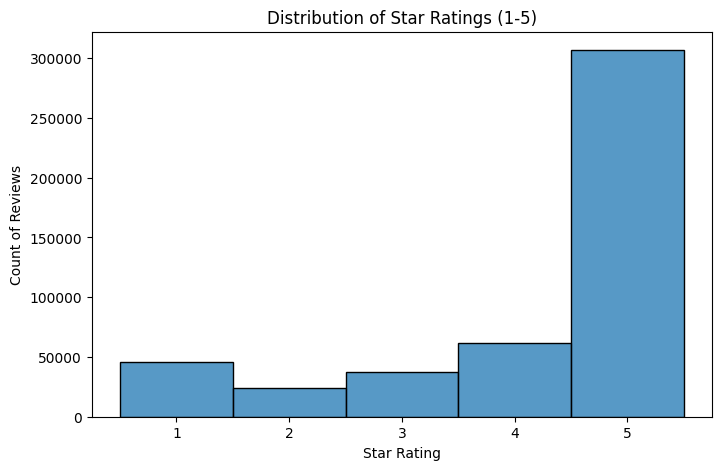

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='rating', bins=5, discrete=True)
plt.title('Distribution of Star Ratings (1-5)')
plt.xlabel('Star Rating')
plt.ylabel('Count of Reviews')
plt.xticks(range(1, 6))
plt.show()

## Top 10 Categories by Review Count

<ipython-input-8-dd493baa48ad>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


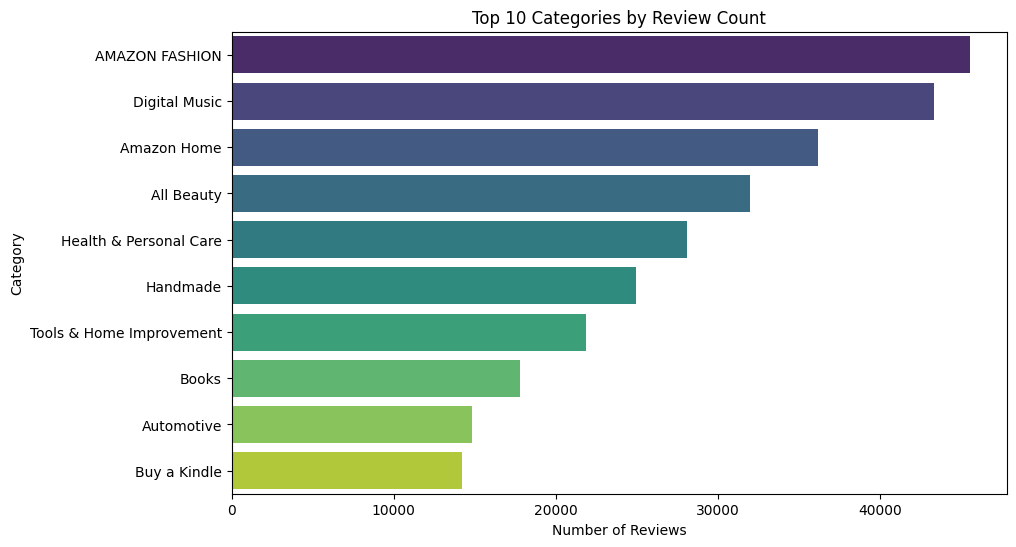

In [ ]:
plt.figure(figsize=(10, 6))
top_categories = df['main_category'].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Top 10 Categories by Review Count')
plt.xlabel('Number of Reviews')
plt.ylabel('Category')
plt.show()

## Top 10 Brands by Review Count (excluding Unknown)

<ipython-input-9-40e8a0fe15f5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='magma')


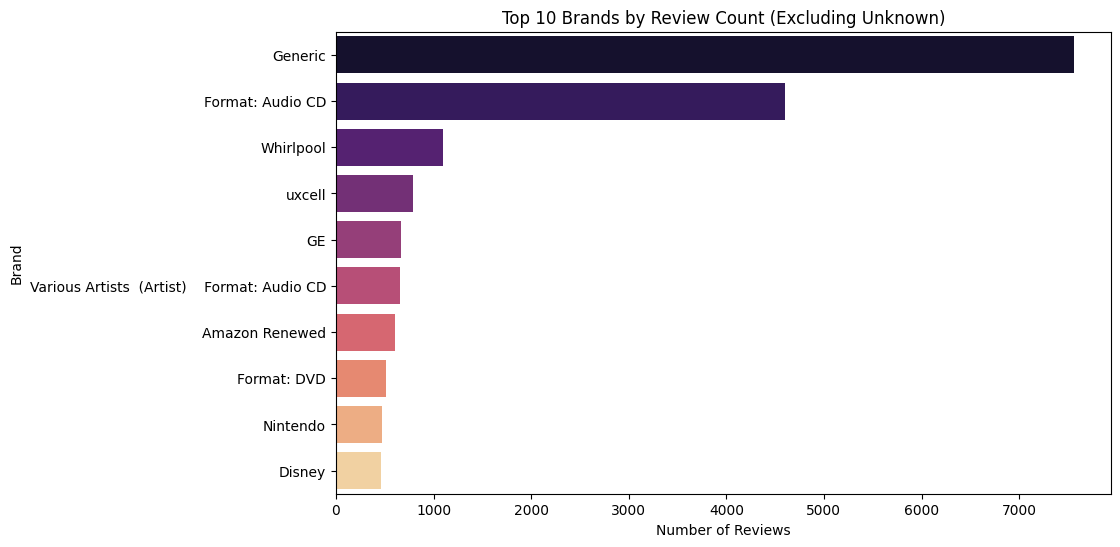

In [ ]:
plt.figure(figsize=(10, 6))
# Assuming brand is in the 'details' dictionary column
top_brands = df[df['brand'] != 'Unknown']['brand'].value_counts().head(10)
sns.barplot(x=top_brands.values, y=top_brands.index, palette='magma')
plt.title('Top 10 Brands by Review Count (Excluding Unknown)')
plt.xlabel('Number of Reviews')
plt.ylabel('Brand')
plt.show()

##  Time-Based Trend of Average Star Rating

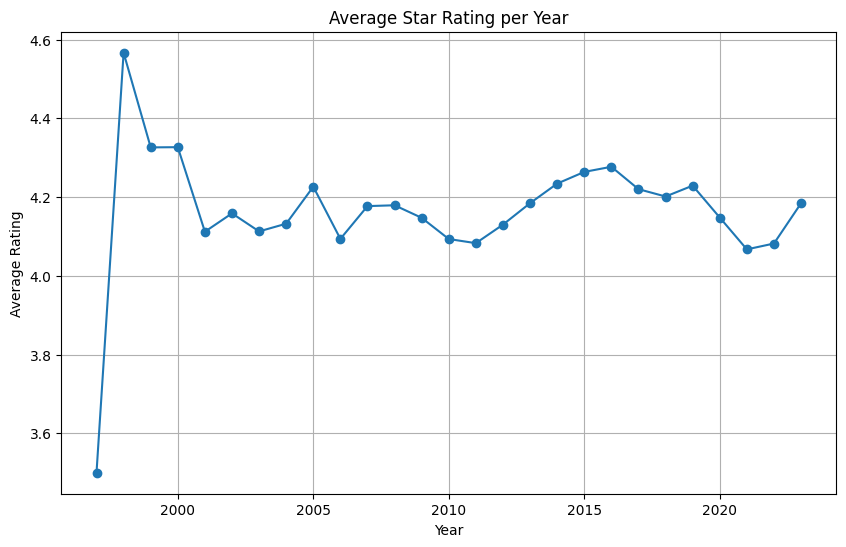

In [ ]:
plt.figure(figsize=(10, 6))
# Convert timestamp to datetime and extract year
yearly_avg = df.groupby('year')['rating'].mean()
yearly_avg.plot(kind='line', marker='o')
plt.title('Average Star Rating per Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

## Correlation between review_length and star-rating

In [ ]:
from scipy.stats import pearsonr

In [ ]:
df['review_length'] = df['text'].apply(len)
corr, p_value = pearsonr(df['review_length'], df['rating'])
print(f"Pearson correlation between review length and star rating: {corr:.3f}")
print("Interpretation: The correlation coefficient indicates the strength and direction of the linear relationship.")
print(f"In this case, the value of {corr:.3f} suggests {'a weak' if abs(corr) < 0.3 else 'a moderate'} {'positive' if corr > 0 else 'negative'} relationship.")


Pearson correlation between review length and star rating: -0.036
Interpretation: The correlation coefficient indicates the strength and direction of the linear relationship.
In this case, the value of -0.036 suggests a weak negative relationship.


**Indicating that as small negative relationship between review length and star rating.**

## Additional Analyses
# Distribution of helpful_vote counts

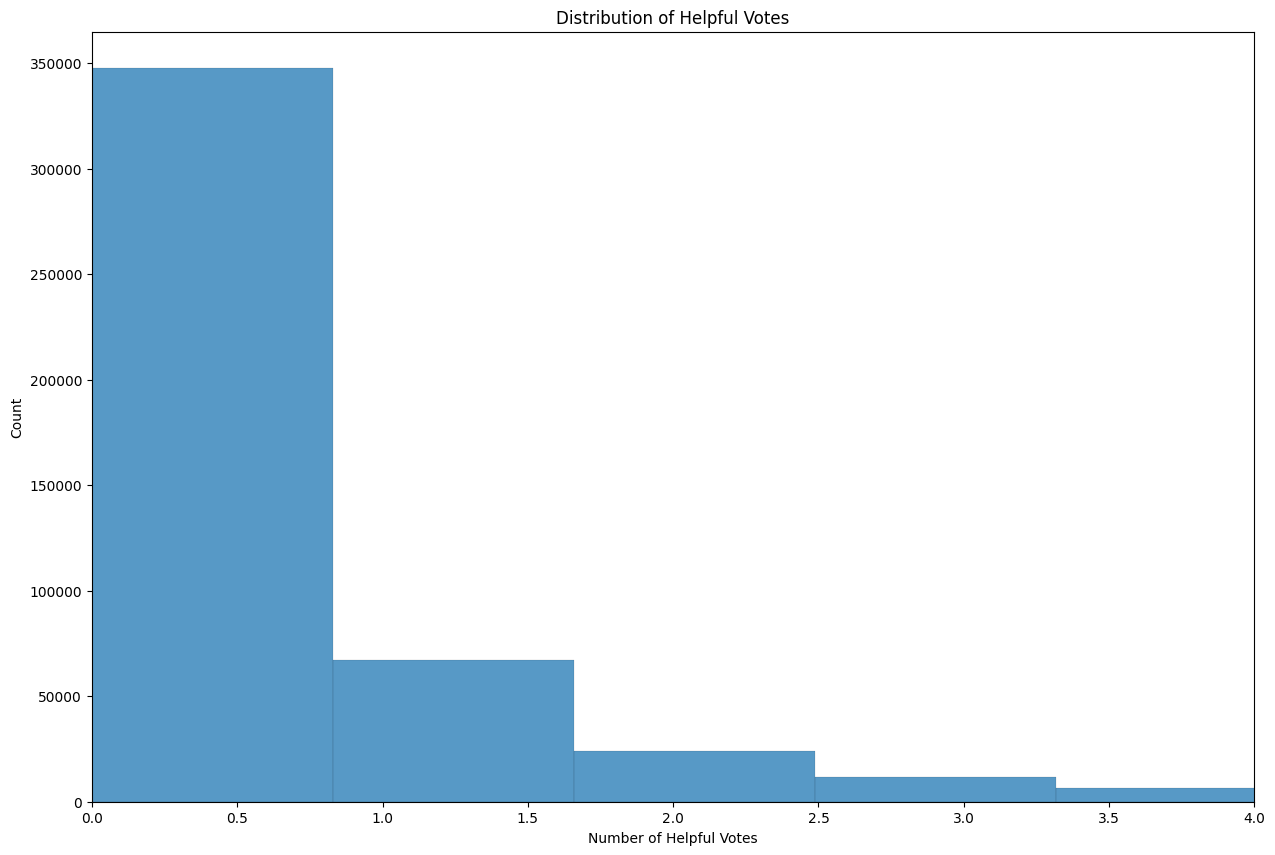

In [ ]:
if 'helpful_vote' in df.columns:
    plt.figure(figsize=(15, 10))
    sns.histplot(data=df, x='helpful_vote', bins=1100)
    plt.title('Distribution of Helpful Votes')
    plt.xlabel('Number of Helpful Votes')
    plt.ylabel('Count')
    plt.xlim(0, df['helpful_vote'].quantile(0.95))  # Show up to 95th percentile to avoid long tail
    plt.show()

# Relationship between verified_purchase and star ratin

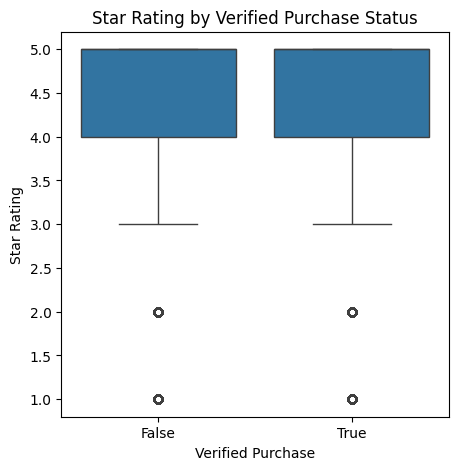

In [ ]:
if 'verified_purchase' in df.columns:
    plt.figure(figsize=(5, 5))
    sns.boxplot(data=df, x='verified_purchase', y='rating')
    plt.title('Star Rating by Verified Purchase Status')
    plt.xlabel('Verified Purchase')
    plt.ylabel('Star Rating')
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

##  Transform rating into binary sentiment

In [ ]:
df['sentiment'] = np.where(df['rating'] > 3, 'Positive', 'Negative')

## Train/Test Split (80/20)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['sentiment'],
    test_size=0.2,
    random_state=42,
    shuffle=True
)

## Text Vectorization with TF-IDF

In [ ]:
tfidf = TfidfVectorizer(
    lowercase=True,
    token_pattern=r'(?u)\b\w\w+\b',  # splits on whitespace/punctuation
    min_df=5,       # discard tokens appearing in fewer than 5 reviews
    max_df=0.8      # discard tokens appearing in more than 80% of reviews
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Number of features (vocabulary size): {len(tfidf.get_feature_names_out())}")

Number of features (vocabulary size): 40581


## Logistic Regression Classifier

In [ ]:
logreg = LogisticRegression(max_iter=1000)  # increased max_iter for convergence
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

## Evaluation

**Predictions**

In [ ]:
y_pred = logreg.predict(X_test_tfidf)

**Accuracy**

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")


Accuracy: 0.8912


**F1 Score**

In [ ]:
f1 = f1_score(y_test, y_pred, pos_label='Positive')
print(f"F1 Score (Positive class): {f1:.4f}")

F1 Score (Positive class): 0.9313


**Confusion Matrix**

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=['Negative', 'Positive'])
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[14652  6939]
 [ 3437 70309]]


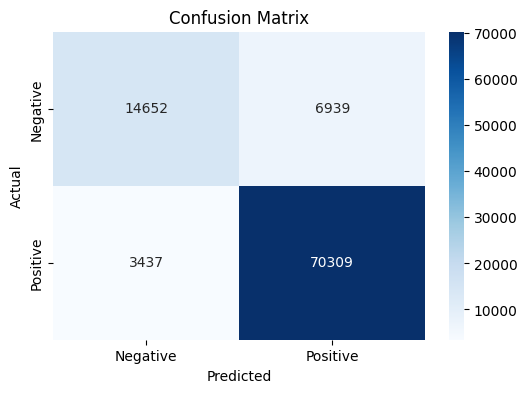

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Recommender System

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ALS Recommender").getOrCreate()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator #Evaluation Metric
from pyspark.ml.recommendation import ALS #Alternating least squares model for collaborative filtering
from pyspark.sql.functions import count #aggregate function
from pyspark.sql.functions import col #treat dataframe column as an object
from pyspark.ml.feature import StringIndexer #Converts string columns to numbers
from pyspark.sql.functions import min, max #Used to get the min and max of rating column
import random #Used to get random users



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = spark.read.csv("/content/drive/My Drive/amazon_data_2023/cleaned_amazon_data.csv", header=True, inferSchema=True) #input cleaned dataset


In [ ]:
df.columns #Ensures all the necessary columns are present

['rating',
 'title_x',
 'text',
 'images_x',
 'asin',
 'parent_asin',
 'user_id',
 'timestamp',
 'helpful_vote',
 'verified_purchase',
 'main_category',
 'title_y',
 'average_rating',
 'rating_number',
 'features',
 'description',
 'price',
 'images_y',
 'videos',
 'store',
 'categories',
 'details',
 'bought_together',
 'subtitle',
 'author',
 'brand',
 'review_length',
 'year']

In [ ]:
review_count = df.count()
print(f"Csv contains {review_count} reviews")

Csv contains 476684 reviews


## Data Setup
Retaining user_id, asin and rating while dropping users with fewer than 5 total
reviews

In [ ]:
user_counts = df.groupBy('user_id').count() #Creates a dataframe based on the unique users


In [ ]:
users_to_keep = user_counts.filter(user_counts['count'] >= 5).select('user_id') #Filter out users with fewer than 5 interaction
filtered_df = df.join(users_to_keep, on='user_id', how='inner')#Keeps rows with users that have at least 5 reviews

In [ ]:
#Cast rating to float
filtered_df = filtered_df.withColumn("rating", col("rating").cast("float"))

In [ ]:
filtered_count = filtered_df.count()
print(f"Amount of rows in the filtered dataframe is {filtered_count}")

Amount of rows in the filtered dataframe is 38384


The filtered dataset contains 38384 rows, which meets the minimum amount for the recommender system.

In [ ]:
#Shows the min and max of the ratings
filtered_df.select(min("rating"), max("rating")).show()

+-----------+-----------+
|min(rating)|max(rating)|
+-----------+-----------+
|        1.0|        5.0|
+-----------+-----------+



## Split
Splitting dataset into an 80% traiing set so the model can have enough data to generalize, while also having enough to confirm model efficiency.

The below code deals with converting the string values of the user_id and asin to numerical indexes due to the Alternating Least Squares method requiring numerical values for processing

In [ ]:
#Convert string columns to usable indexes
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index",handleInvalid="skip")
item_indexer = StringIndexer(inputCol="asin", outputCol="item_index",handleInvalid="skip")

#Apply indexed data to filtered dataset
indexed_data = user_indexer.fit(filtered_df).transform(filtered_df)
indexed_data = item_indexer.fit(indexed_data).transform(indexed_data)
#Randomly splits dataset into an 80% train set and 20% test set
(training, test) = indexed_data.randomSplit([0.8, 0.2], seed=42)

## Alternating Least Squares
The Spark ML library was chosen to implement alternating least squares due to its ability to handle large datasets, its high processing speed as well as its ease of implementation.

The below code utilizes manual als tuning to find the best hyperparameters for the model. It evaluates multiple combinations of hyperparameters (rank, regularization parameter, and maximum iterations)

In [ ]:
#Define the evaluator to assess model performance using RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

In [ ]:
def als_tuning(training, test, ranks, regParams, maxIters):
    #Initialize variables to store best parameters and model
    best_model = None
    best_rmse = float("inf") #Stores large value so any RMSE can be better than it
    best_params = None
    #Loops through the different combinations of parameters
    for rank in ranks:
        for reg in regParams:
            for max_iter in maxIters:
                als = ALS(
                    userCol="user_index",
                    itemCol="item_index",
                    ratingCol="rating",
                    coldStartStrategy="drop",
                    nonnegative=True,
                    implicitPrefs=False,
                    rank=rank,
                    maxIter=max_iter,
                    regParam=reg
                )

                model = als.fit(training) #Fit the ALS model on the training data
                predictions = model.transform(test) #Make predictions on the test data
                rmse = evaluator.evaluate(predictions) #Evaluate model using RMSE

                print(f"Rank: {rank}, RegParam: {reg}, MaxIter: {max_iter} || RMSE: {rmse}") #Print current combination of parameters and corresponding RMSE value
                #Update the best model and parameters if rmse  is lower the the current best RMSE
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_params = (rank, reg, max_iter)

    print(f"\nBest RMSE: {best_rmse} with Rank: {best_params[0]}, RegParam: {best_params[1]}, MaxIter: {best_params[2]}")
    return best_model


In [ ]:
#List of hyperparameters for tuning the ALS model
ranks = [8, 10, 12]
regParams = [0.05, 0.1, 0.15]
maxIters = [10, 15]

## Evaluation
Different combinations of hyperparamters were chosen to train and evaluate the model. The model with the lowest RMSE score will be chosen to make predictions.

In [ ]:
best_model = als_tuning(training, test, ranks, regParams, maxIters)

Rank: 8, RegParam: 0.05, MaxIter: 10 || RMSE: 0.9626941988288471
Rank: 8, RegParam: 0.05, MaxIter: 15 || RMSE: 0.9658879752223287
Rank: 8, RegParam: 0.1, MaxIter: 10 || RMSE: 0.9940081117607227
Rank: 8, RegParam: 0.1, MaxIter: 15 || RMSE: 1.0035237992723878
Rank: 8, RegParam: 0.15, MaxIter: 10 || RMSE: 1.0330511399638678
Rank: 8, RegParam: 0.15, MaxIter: 15 || RMSE: 1.0479245933433168
Rank: 10, RegParam: 0.05, MaxIter: 10 || RMSE: 0.9640274068999336
Rank: 10, RegParam: 0.05, MaxIter: 15 || RMSE: 0.9669068285722151
Rank: 10, RegParam: 0.1, MaxIter: 10 || RMSE: 0.9943001757165887
Rank: 10, RegParam: 0.1, MaxIter: 15 || RMSE: 1.0037625979709999
Rank: 10, RegParam: 0.15, MaxIter: 10 || RMSE: 1.0331387718763871
Rank: 10, RegParam: 0.15, MaxIter: 15 || RMSE: 1.049047060584209
Rank: 12, RegParam: 0.05, MaxIter: 10 || RMSE: 0.9649358774209971
Rank: 12, RegParam: 0.05, MaxIter: 15 || RMSE: 0.9663680178728038
Rank: 12, RegParam: 0.1, MaxIter: 10 || RMSE: 0.9933270762978792
Rank: 12, RegParam: 0.

From the fine tuning above, it can be seen that the best RMSE was  0.9631 with a Rank of 8, RegParam of 0.05 and MaxIter of 10.
This relatively low RMSE suggests that the model has strong predictive performance and is well-suited for the task at hand. It also suggests that the patterns in the data are learnable and the variability of ratings is somewhat predictable. Though, there is room for improvement with better fine tuning, and a train/validation/test split.


## Demo

In [ ]:
"""Function to get top n recommendations for a specified number of users"""
def top_recommendations(model,test, indexed_data, num_users=3, top_n=5):

    unique_users = test.select("user_index").distinct()
    user_ids = [row["user_index"] for row in unique_users.collect()]

    random_users = random.sample(user_ids, num_users)
    print(f"Randomly selected user indices: {random_users}")

    #Recommend for each user
    all_items = indexed_data.select("item_index").distinct()

    for user_id in random_users:
        #Create pairs of users and items
        user_df = all_items.withColumn("user_index", col("item_index") * 0 + user_id)

        #Generate predictions
        user_recommendations = model.transform(user_df).filter(col("prediction").isNotNull())

        #top recommendations
        top_recommendations = user_recommendations.orderBy(col("prediction").desc()).limit(top_n)

        #Display results
        print(f"\nTop {top_n} recommendations for user_index {user_id}:")
        top_recommendations.select("item_index", "prediction").show()



In [ ]:
top_recommendations(best_model, test, indexed_data)

Randomly selected user indices: [1019.0, 2304.0, 4084.0]

Top 5 recommendations for user_index 1019.0:
+----------+----------+
|item_index|prediction|
+----------+----------+
|   12121.0| 5.2859592|
|   18416.0| 5.2859592|
|   11024.0| 5.2577105|
|   17536.0| 5.2577105|
|   21716.0| 5.2370405|
+----------+----------+


Top 5 recommendations for user_index 2304.0:
+----------+----------+
|item_index|prediction|
+----------+----------+
|   28516.0| 5.7482314|
|   16031.0| 5.7482314|
|   24047.0| 5.7482314|
|    7035.0| 5.7482314|
|   11991.0|  5.636387|
+----------+----------+


Top 5 recommendations for user_index 4084.0:
+----------+----------+
|item_index|prediction|
+----------+----------+
|   15292.0|  5.999779|
|   16534.0|  5.999779|
|    8724.0|  5.999779|
|    8729.0|  5.999779|
|   24262.0|  5.995158|
+----------+----------+



The recommendations for each user show that the model is able to generate meaningful predictions based on the user’s past interactions. The predicted ratings are fairly high, suggesting that the model is efficient in identifying items that are relevant to the users.

#Clustering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/amazon_data_2023/cleaned_amazon_data.csv')

**Aggregating Review Data at Product Level**

To prepare for clustering, we aggregate the review data at the product level using `asin`. For each product, we calculate:
- **Mean Rating**: The average star rating given by users
- **Total Reviews**: The number of reviews
- **Brand**: Captures the manufacturer or label behind the product
 **Main Category**: Represents the top-level product classification

This gives us a clean `product_df` where each row represents one unique product.

In [ ]:
product_df = df.groupby('asin').agg({
    'rating': 'mean',
    'text': 'count',
    'brand': 'first',
    'main_category': 'first'
}).reset_index()

product_df.columns = ['asin', 'mean_rating', 'total_reviews', 'brand', 'main_category']

product_df.head()

,asin,mean_rating,total_reviews,brand,main_category
0,0001046519,5.0,1,Oscar Wilde Trevor Millum Format: Audio Ca...,Digital Music
1,0001048236,5.0,1,Format: Audio Cassette,Digital Music
2,000105001X,1.0,1,Barbara Erskine Format: Audio Cassette,Digital Music
3,0001050028,3.0,1,Barbara Erskine Format: Audio Cassette,Digital Music
4,0001050818,4.0,1,"Kathy Tyers (Author), Anthony Heald (Author)",Books


**Encoding Categorical Features**

Since KMeans require numerical input, we convert the `brand` and `main_category` columns into numeric codes using `LabelEncoder`.  

Missing values are replaced with `"Unknown"` to ensure encoding works smoothly.

In [ ]:
product_df['brand'] = product_df['brand'].fillna('Unknown')
product_df['main_category'] = product_df['main_category'].fillna('Unknown')

brand_encoder = LabelEncoder()
category_encoder = LabelEncoder()

product_df['brand_id'] = brand_encoder.fit_transform(product_df['brand'])
product_df['category_id'] = category_encoder.fit_transform(product_df['main_category'])

print("Brand Encoding Examples:")
for brand, code in zip(brand_encoder.classes_[:5], brand_encoder.transform(brand_encoder.classes_[:5])):
    print(f"  {brand} → {code}")


print("\nCategory Encoding Examples:")
for category, code in zip(category_encoder.classes_[:5], category_encoder.transform(category_encoder.classes_[:5])):
    print(f"  {category} → {code}")

Brand Encoding Examples:
  "Best Friend" Winnie the Pooh Latch Hook → 0
  "Country Gent" → 1
  "Dream Baby" → 2
  "Little" Louie Vega   Format: Audio CD → 3
  "N/A" → 4

Category Encoding Examples:
  AMAZON FASHION → 0
  All Beauty → 1
  All Electronics → 2
  Amazon Devices → 3
  Amazon Fire TV → 4


**Scaling Features for Clustering**

The features `mean_rating`, `total_reviews`, `brand_id`, and `category_id` have different scales. We normalize them using `StandardScaler` to ensure that no single feature dominates the distance calculations in KMeans.  

In [ ]:
features = product_df[['mean_rating', 'total_reviews', 'brand_id', 'category_id']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_features[:5]

array([[ 0.62219484,  0.        ,  0.4317288 ,  0.01949312],
       [ 0.62219484,  0.        , -0.72225964,  0.01949312],
       [-2.38916487,  0.        , -1.43113803,  0.01949312],
       [-0.88348502,  0.        , -1.43113803,  0.01949312],
       [-0.13064509,  0.        , -0.16608841, -0.52232181]])

**Applying KMeans Clustering and Evaluating Cluster Size**

We apply KMeans clustering with k = 5 as required. After assigning cluster labels to each product, we evaluate the quality of the clustering:

- **Inertia**: Measures how tightly the clusters are formed. Given that k=5 was specified, the value 447,989.93 simply confirms that the algorithm converges successfully.
- **Silhouette Score**: Measures how well each point fits within its cluster. The score of 0.341 indicates moderate cluster quality, implying the products are reasonably well-separated, with some overlap.

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
product_df['cluster'] = kmeans.fit_predict(scaled_features)

print(f"Inertia for k=5: {kmeans.inertia_}")

sample_df = product_df.groupby('cluster', group_keys=False).apply(lambda x: x.sample(min(len(x), 1000), random_state=42))
sample_scaled = scaled_features[sample_df.index]
score = silhouette_score(sample_scaled, sample_df['cluster'])
print(f"Silhouette Score (k=5): {score}")

Inertia for k=5: 447989.9292855936
Silhouette Score (k=5): 0.34136181846840025


**Analyzing Review Count Distribution**

To better understand our data structure, we examine the distribution of `total_reviews` across products. This helps explain cluster shape, as most products appear to have few reviews while some (long-tail) have thousands.

In [ ]:
product_df['total_reviews'].describe()

,total_reviews
count,476684.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


**Examining Cluster Sizes**

Overall, the clusters are relatively well-balanced in size, which indicates that the segmentation captured meaningful groupings within the data.

In [ ]:
print("Products per Cluster:")
print(product_df['cluster'].value_counts().sort_index())

Products per Cluster:
cluster
0    112712
1     87396
2     87393
3    113348
4     75835
Name: count, dtype: int64


**Cluster Summary**

- **Clusters 0, 1, 2, and 3** all show high average ratings (4.64–4.72), suggesting they contain positively reviewed products.

- **Cluster 4** is notably different, with a low mean rating of 1.47.

- The average total_reviews is 1.0 across all clusters, indicating each product appears once in the dataset, likely due to aggregation or sampling method.

In [ ]:
cluster_summary = product_df.groupby('cluster').agg({
    'asin': 'count',
    'mean_rating': 'mean',
    'total_reviews': 'mean',
    'brand_id': 'mean',
    'category_id': 'mean'
}).rename(columns={'asin': 'cluster_size'})

display(cluster_summary)

,cluster_size,mean_rating,total_reviews,brand_id,category_id
cluster,,,,,
0,112712,4.724129,1.0,54972.472248,31.170647
1,87396,4.646986,1.0,164638.869319,6.157696
2,87393,4.644319,1.0,52592.200405,6.591386
3,113348,4.704415,1.0,167290.400633,32.724177
4,75835,1.473554,1.0,114043.725944,20.260302


**PCA Visualization of Clusters**

- The clusters appear visibly distinct, with noticeable separation between most groups, indicating meaningful structure in the data.
- **Cluster 2 (orange)** is fairly concentrated near the center, possibly representing products with average values across features.
- **Clusters 0, 1, 3, and 4** fan outward in different directions, suggesting diverse product groups in terms of category or brand dominance.
- The clear boundaries between clusters support the silhouette score obtained earlier (~0.34), which indicated moderately well-separated clusters with some overlap.

This visualization confirms that the clustering structure is not random and that the features chosen effectively differentiate product groups.


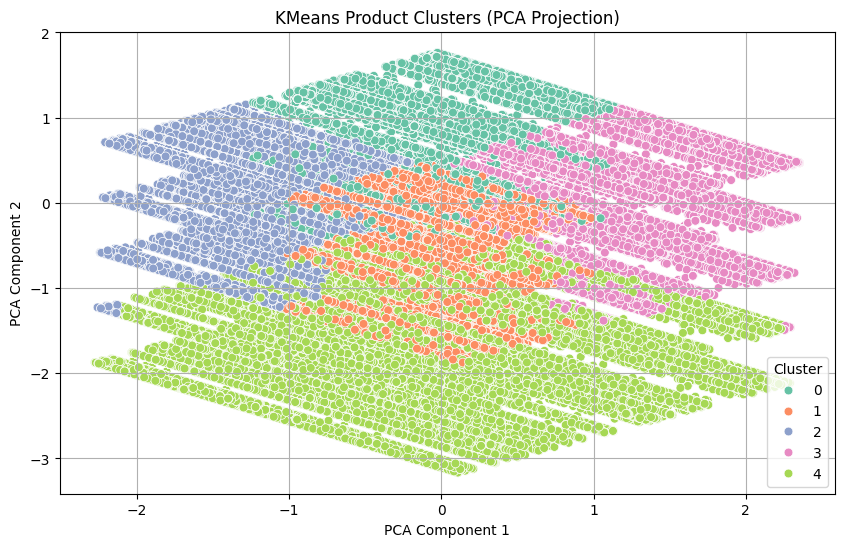

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

plt.figure(figsize=(10,6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=product_df['cluster'], palette='Set2', s=40)
plt.title('KMeans Product Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()